# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *

if USE_GPU:
    print(torch.cuda.is_available())

False


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=sample_transform)

Bounding box [x_min, y_min, x_max, y_max]: [ 735.51354832  364.85722843 1130.80900426  730.14928904]


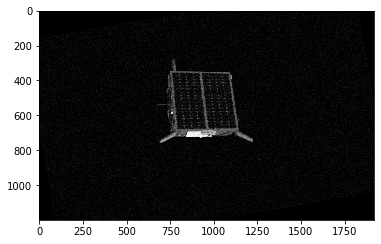

In [4]:
img, label = sample_dataset[100]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Data augmentation considerations
To increase the size of the training set and its variability, we can augment the training set via common image transformations. Transformations suitable to the task (TBD):
- Random rotation
- Random noise
- Zoom/cropping
- any other?

Before we start the training (and the actual data augmentation), we will need to resize all the images; a suitable transform should take care of this in an online fashion. **However, resizing the image will affect the camera intrinsics and as a result, the bounding box estimates**. For this reason, we will probably need to compute the bounding box in an online fashion as well (unless we can somehow define the bounding box such that it is invariant to the resizing operation, e.g. define bounding box coordinates with respect to center of spacecraft frame or image frame so that it is not affected by a center crop).

A new camera intrinsics matrix $K'$ can be generated by applying the following transformation:

$$K' = TK = \begin{bmatrix}d2_w/d1_w&0&0\\0&d2_h/d1_h&0\\0&0&1\end{bmatrix}$$

where $d1_i$ represents the dimensions of the original image and $d2_i$ those of the resized image

## Dataloading

In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomRotation((-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

sanity_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5],[0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [6]:
# Datasets
train_dataset = SpeedDataset(
    split="train",
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

val_dataset = SpeedDataset(
    split="test",
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=val_transform
)

In [7]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=WORKERS, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)

## Existing network implementations (1/2)

The following is a pytorch implementation of [Deep3dBox](https://arxiv.org/pdf/1612.00496.pdf). Geometric constraints are used to solve for the translation (even though it is known to lock errors in if the 2D bounding box is inaccurate; see [MonoPSR](https://arxiv.org/pdf/1904.01690.pdf) or [Cascade geometric constratins](https://arxiv.org/pdf/1909.01867.pdf) for better alternatives). However, all these approaches focus on 3D bounding box estimation for cars and as a result, they can make pretty big assumptions about the orientation of the vehicle (i.e., roll and pitch equal to zero). These papers use multi-task CNN and multi-bin losses and would need to be extended to recover the full 6DOF.

In [9]:
# Pre-trained layers
vgg = models.vgg19_bn(pretrained=True)

In [10]:
# Input size: 224x224 (imposed by vgg pretrained layers)

def OrientationLoss(orient_batch, orientGT_batch, confGT_batch):

    batch_size = orient_batch.size()[0]
    indexes = torch.max(confGT_batch, dim=1)[1]

    # extract just the important bin
    orientGT_batch = orientGT_batch[torch.arange(batch_size), indexes]
    orient_batch = orient_batch[torch.arange(batch_size), indexes]

    theta_diff = torch.atan2(orientGT_batch[:,1], orientGT_batch[:,0])
    estimated_theta_diff = torch.atan2(orient_batch[:,1], orient_batch[:,0])

    return -1 * torch.cos(theta_diff - estimated_theta_diff).mean()


class Deep3dBoxNet(nn.Module):
    def __init__(self, features=None, bins=2, w = 0.4):
        super(Deep3dBoxNet, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features
        self.orientation = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins*2) # to get sin and cos
                )
        self.confidence = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins),
                    # nn.Softmax()
                    #nn.Sigmoid()
                )
        self.dimension = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 3)
                )

    def forward(self, x):
        x = self.features(x) # 512 x 7 x 7
        x = x.view(-1, 512 * 7 * 7)
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)
        confidence = self.confidence(x)
        dimension = self.dimension(x)
        return orientation, confidence, dimension

In [12]:
# Testing model with pretrained weights (epoch10) on Kitti
weight_filepath = '../weights/epoch_10.pkl'
model = Deep3dBoxNet(features=vgg.features, bins=2).cuda()
checkpoint = torch.load(weight_filepath)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

## Existing network implementations (2/2)
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons. Being more straightforward, this implementation is more suited to a study of domain adaptation.

In [8]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [15]:
class URSONet(nn.Module):
    def __init__(self, criterion=None):
        super(URSONet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        
        # Translation branch: t = [tx, ty, tz]
        self.fc_t = nn.Linear(4*4*1024, 3)

        # Attitude branch: q = [q0, q1, q2, q3]
        # NOTE: this assumes quaternions as attitude descriptors
        self.fc_att = nn.Linear(4*4*1024, 4)
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        x = self.resnet(input)
        x = self.conv6(x)

        t = self.fc_t(x)
        att = self.fc_att(x)

        return t, att

### Training

In [20]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

In [21]:
def translation_loss(t, t_est):
    return torch.norm(t - t_est)/torch.norm(t_est)

In [23]:
def attitude_loss(att, att_est):
    #TODO: should not take L2 norm of quaternion difference --> find better more accurate loss metric
    return torch.norm(att - att_test)

In [24]:
def train(train_loader, net, optimizer, loss_graph):
    for i, data in enumerate(train_loader):
        inputs, target = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
        att_gt = target[:4]
        t_gt = target[4:7]

        optimizer.zero_grad()
        t, att = net(inputs)
        L_t = translation_loss(t, t_gt)
        L_att = attitude_loss(att, att_gt)
        total_loss = L_t + L_att

        # loss_graph.append(total_loss.item())
        total_loss.backward()
        optimizer.step()